# Invariant Layer

## Intro
* **Date**: 1/4/2021
* **What**: I'm finally implementing the invariant layer!  Basically, the invariant layer should have the property of changing smoothly throughout time, which is obviously contrasted with the sparse layer, which essentially fires randomly throughout time.
* **Why**: My strong hypothesis is that perception is the process of finding structure in an incoming data-stream, and figuring out which of those structures are related.  In other words, it's all about finding invariant representations.  So, I'm trying to figure out how the network can learn that a handwritten 7 is still a 7 if it's shifted over 10 pixels.  With sparse coding alone, the network has no way of knowing that those two structures are related.  However, I'm making the basic assumption that the universe transforms smoothly throughout time, so if you find that two structures are related throughout time, you can effectively say that they are two representations of the same invariant structure.  So yeah, invariant representations are everything.
* **Hopes**: Because I haven't really figured out how to impose high-level hypotheses on lower layers, really the most I can do is train the invariant layer, and watch it evolve throughout time.  Hopefully the invariant layer will change smoothly throughout time. That's basically all I can hope for.
* **Limitations**: I'm honestly not really sure.  I'm trying something new, and typically when I do that everything tends to break, so I just really hope I see at least some reasonably good behavior from the invariant layer.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 3000

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


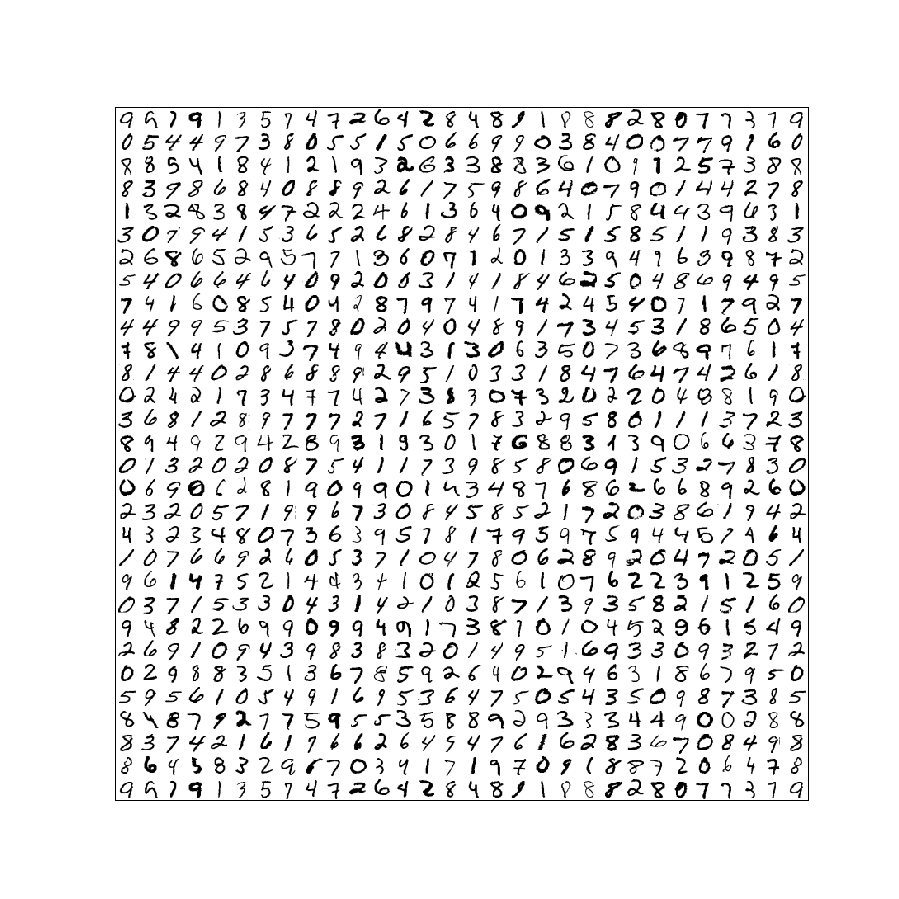

In [2]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

A simply magnificent tapestry.

In [3]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 100_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


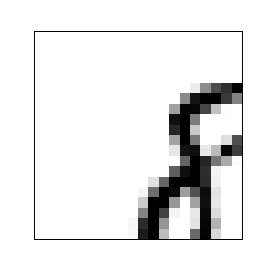

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

Excellent.

In [5]:
tap_val = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 10000

for x in range(t_sl):
    for y in range(t_sl):

        tap_val[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tap_val[(t_sl - 1) * m_sl:, :] = tap_val[: m_sl, :]
tap_val[:, (t_sl - 1) * m_sl:] = tap_val[:, : m_sl]

<IPython.core.display.Javascript object>


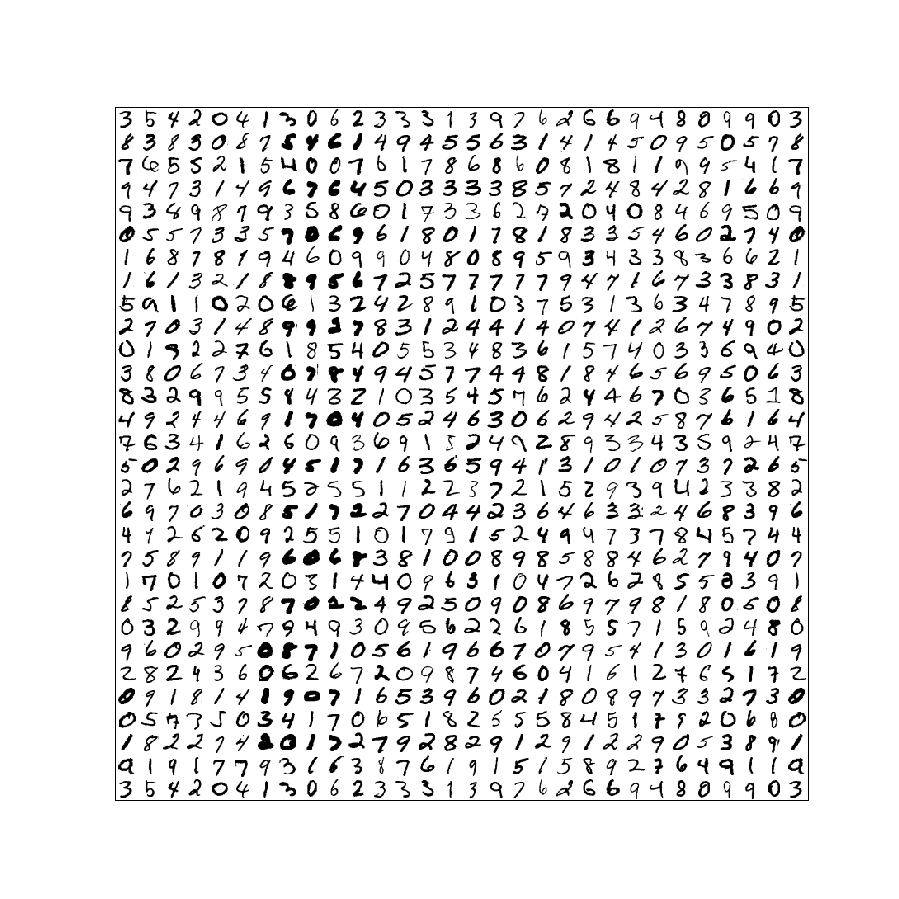

In [6]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tap_val, cmap="gray_r")

In [7]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_val = img_array.reshape(-1, sl ** 2)
gp_val = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


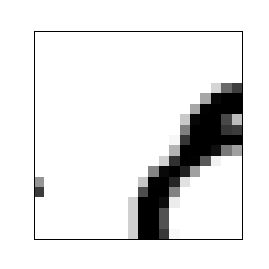

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

## Analysis Dialog

Ok, here goes!  

<IPython.core.display.Javascript object>


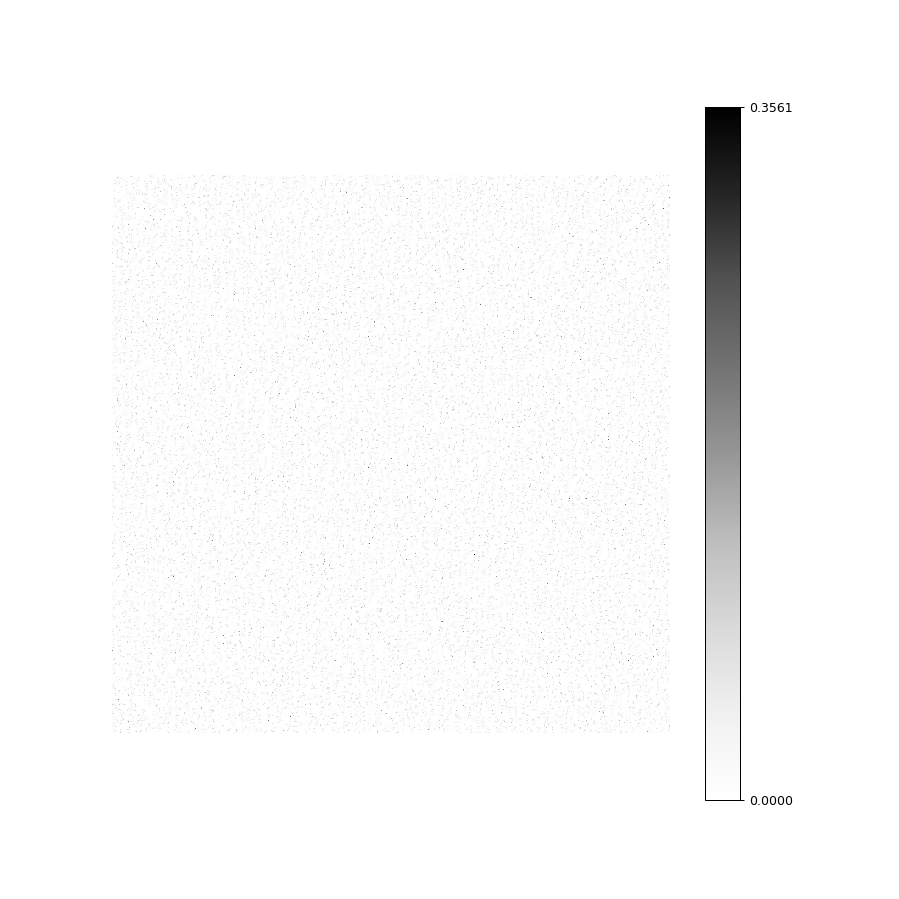

100%|██████████| 10000/10000 [00:14<00:00, 694.57it/s]


In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 100
Ky = 100
sN = Kx * Ky
m_len = sl ** 2

n_w = 10 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 20
Iy = 20
iN = Ix * Iy

iw = cp.random.uniform(0, 0.5, (iN, sN))
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        io_p = cp.maximum((2 * io_b) - io_bb, 0)
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io

    draw_weights(sw.get(), Kx, Ky, sl, fig)

Ok, here's to hoping the invariant layer varies smoothly...

<IPython.core.display.Javascript object>


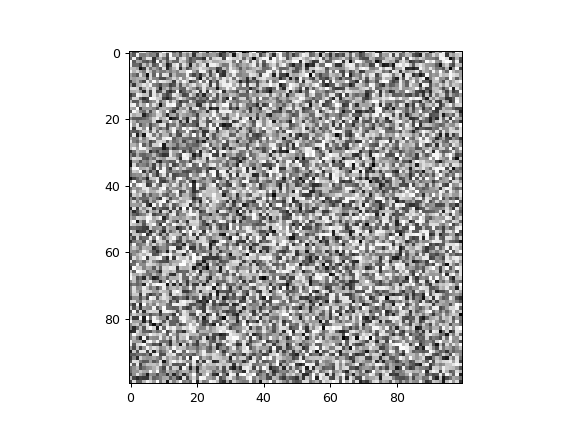

In [18]:
plt.figure()
plt.imshow(iw[1].reshape(100, 100).get(), cmap='gray_r')

<IPython.core.display.Javascript object>


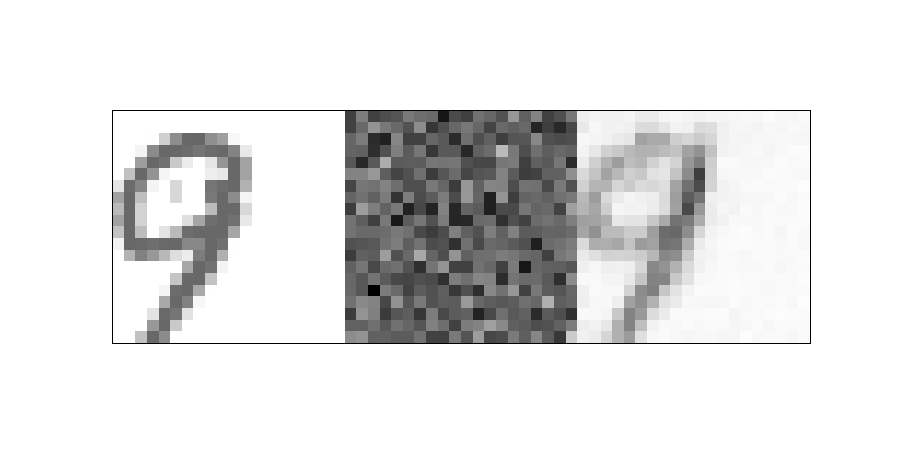

100%|██████████| 500/500 [00:05<00:00, 91.86it/s]


In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = io.reshape(20, 20)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

I straight-up can't tell if that's working, even a little bit.  Here's what I'm going to do.  I'm going to train this bad boi again, this time with more data, and then I'm going to see the extent to which the invariant layer is changing smoothly.  I also just realized I was using 10 winner, so lord only knows how that messed it up.

<IPython.core.display.Javascript object>


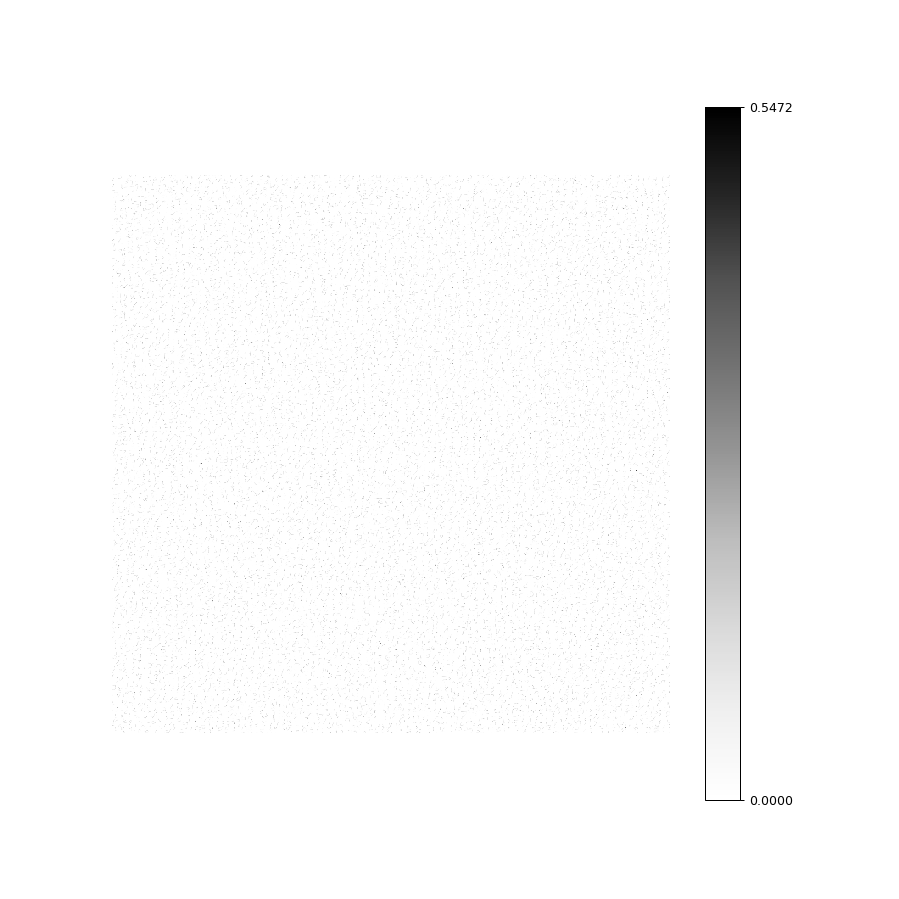

100%|██████████| 100000/100000 [02:22<00:00, 699.67it/s]


In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 3
T_s = 100000
prec = 1e-10

# Sparse Layer
Kx = 100
Ky = 100
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 20
Iy = 20
iN = Ix * Iy

iw = cp.random.uniform(0, 0.3, (iN, sN))
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        io_p = cp.maximum((2 * io_b) - io_bb, 0)
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io

    draw_weights(sw.get(), Kx, Ky, sl, fig)

First, here's an image of one of the invariant layer's weight-prototype.

<IPython.core.display.Javascript object>


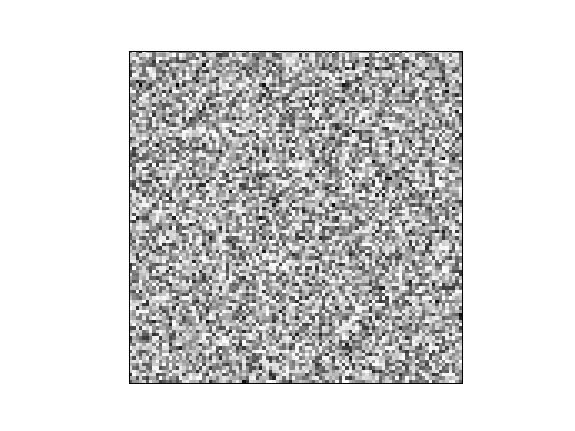

In [28]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(iw[1].reshape(Kx, Ky).get(), cmap='gray_r')

I honestly don't really know what to think.  Here's the basic animation first.

<IPython.core.display.Javascript object>


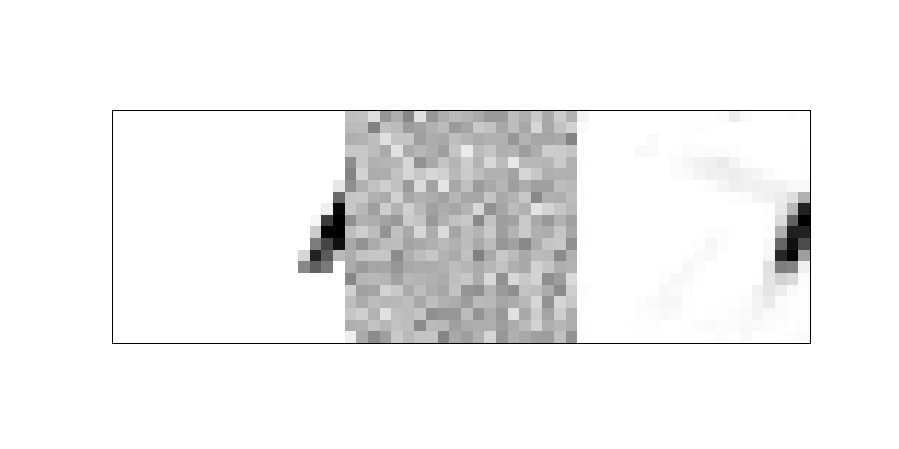

100%|██████████| 500/500 [00:05<00:00, 89.24it/s]


In [29]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = io.reshape(20, 20)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Well, it seems like it's lighter this time.  In this next animation, I'm going to plot the linear prediction in addition to the actual invariant output.

<IPython.core.display.Javascript object>


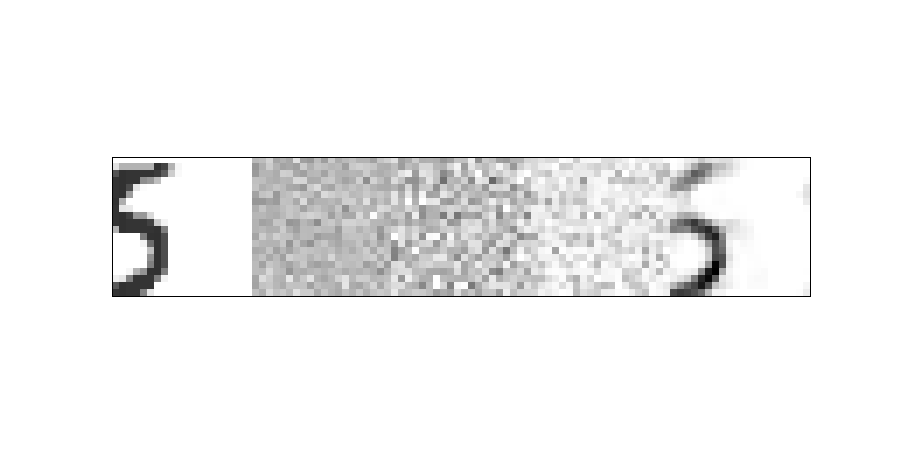

100%|██████████| 500/500 [00:05<00:00, 94.64it/s]


In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))

for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    io_p = np.maximum((2 * io_b) - io_bb, 0)
    
    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:, 20:40] = io.reshape(20, 20)
    mini_tap[:, 40:60] = io_p.reshape(20, 20)
    mini_tap[:, 60:80] = np.abs(io - io_p).reshape(20, 20)    
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, you know what?  I need to train this on a smaller network so I can actually see what's going on with the prototypes.

<IPython.core.display.Javascript object>


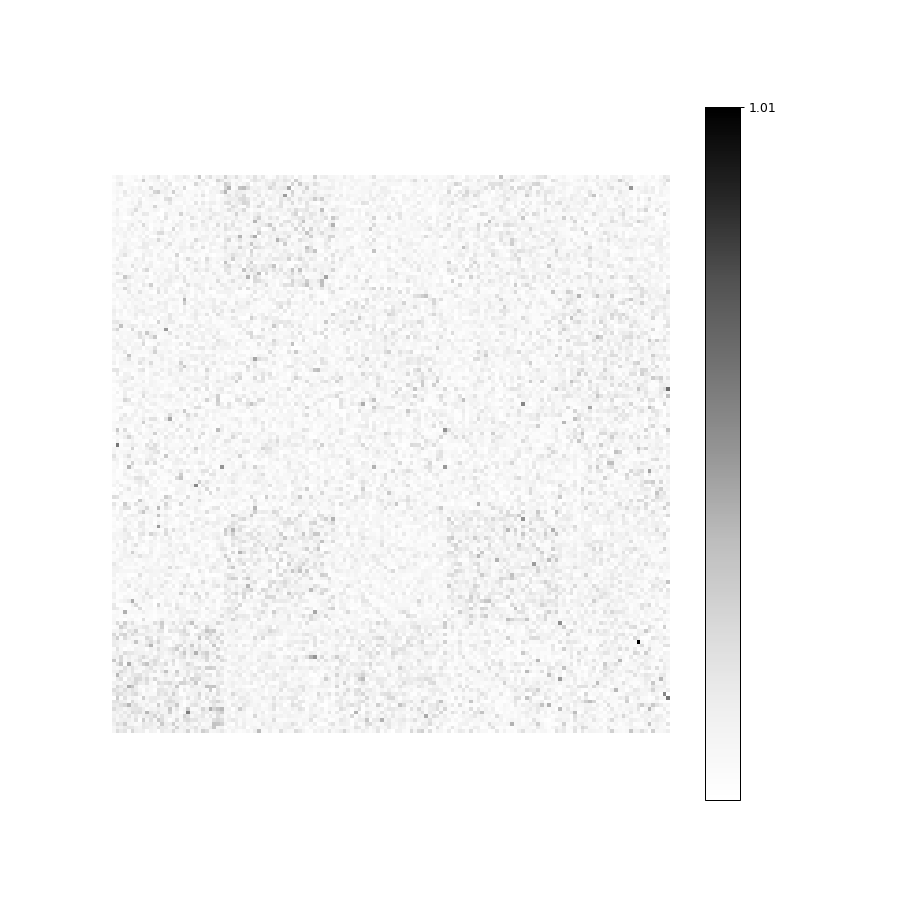

100%|██████████| 10000/10000 [00:09<00:00, 1049.49it/s]


In [38]:
%matplotlib notebook
fig1 = plt.figure(figsize=(10, 10))
# fig2 = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 5
Iy = 5
iN = Ix * Iy

iw = cp.random.uniform(0, 0.3, (iN, sN))
zeta = 0.3


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        io_p = cp.maximum((2 * io_b) - io_bb, 0)
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io

#     draw_weights(sw.get(), Kx, Ky, sl, fig1)
    draw_weights(iw.get(), Ix, Iy, Kx, fig1)

<IPython.core.display.Javascript object>


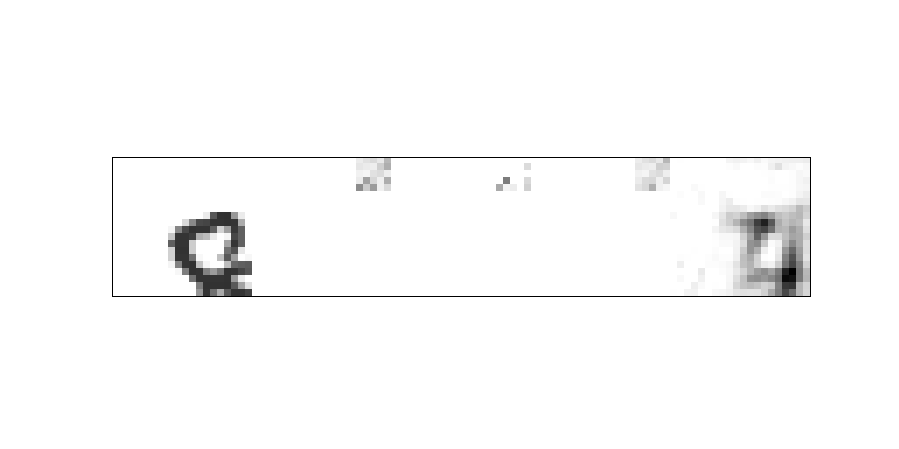

100%|██████████| 500/500 [00:01<00:00, 395.44it/s]


In [45]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))

for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    io_p = np.maximum((2 * io_b) - io_bb, 0)
    
    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 5
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:5, 40 - glee:40] = io.reshape(5, 5)
    mini_tap[:5, 60 - glee:60] = io_p.reshape(5, 5)
    mini_tap[:5, 80 - glee:80] = np.abs(io - io_p).reshape(5, 5) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


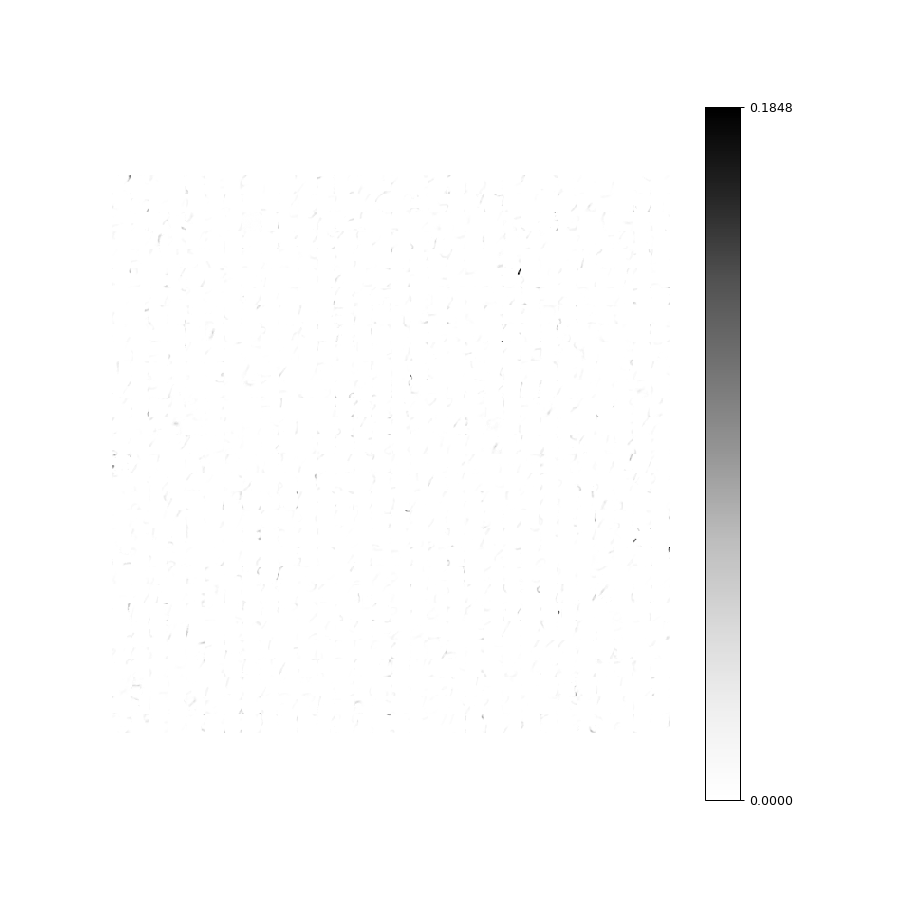

In [49]:
fig = plt.figure(figsize=(10, 10))

draw_weights((sw * iw[-1].reshape(-1, 1)).get(), Kx, Ky, sl, fig)

Yeah, this isn't making any sense.  I think I'm going to bump up the initial weights, and lower the learning constant, and train that bad boi on like literally a million epochs.  I'm also going to use 16 neurons.

<IPython.core.display.Javascript object>


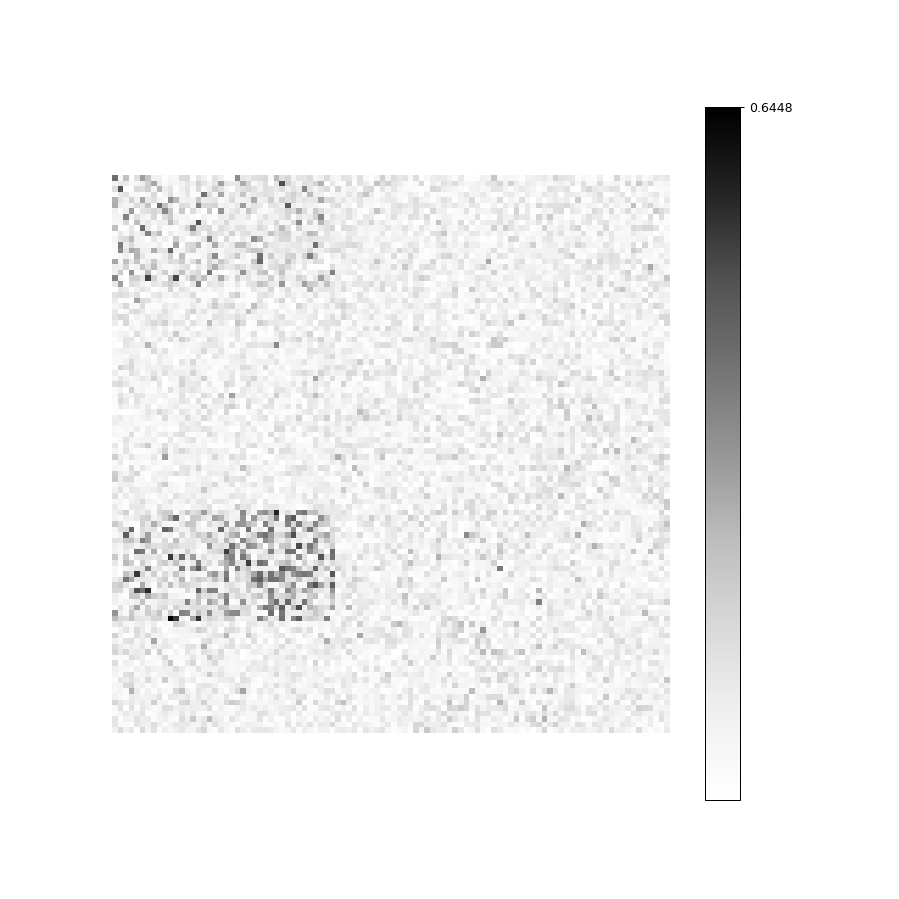

100%|██████████| 10000/10000 [00:09<00:00, 1043.21it/s]


In [50]:
%matplotlib notebook
fig1 = plt.figure(figsize=(10, 10))
# fig2 = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 5
Iy = 5
iN = Ix * Iy

iw = cp.random.uniform(0, 1, (iN, sN))
zeta = 0.05


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        io_p = cp.maximum((2 * io_b) - io_bb, 0)
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io

#     draw_weights(sw.get(), Kx, Ky, sl, fig1)
    draw_weights(iw.get(), Ix, Iy, Kx, fig1)

<IPython.core.display.Javascript object>


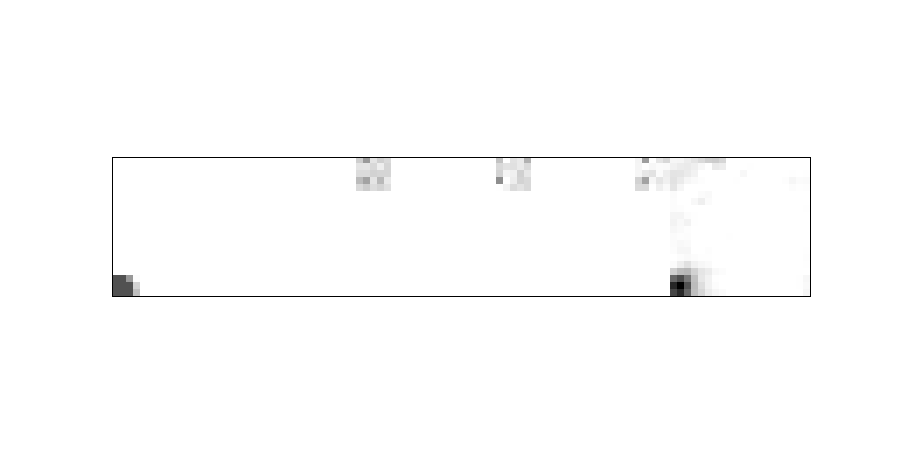

100%|██████████| 500/500 [00:01<00:00, 439.41it/s]


In [51]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))

for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    io_p = np.maximum((2 * io_b) - io_bb, 0)
    
    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 5
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:5, 40 - glee:40] = io.reshape(5, 5)
    mini_tap[:5, 60 - glee:60] = io_p.reshape(5, 5)
    mini_tap[:5, 80 - glee:80] = np.abs(io - io_p).reshape(5, 5) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, that's super not working.  I'm going to try a new tactic.  I was trying to linearly predict the invariant output from the previous two outputs, but that appears to be no good.  

Actually, before I hang this up, I'm going to try training the layer on a much larger number of invariant neurons and see if that helps anything.

<IPython.core.display.Javascript object>


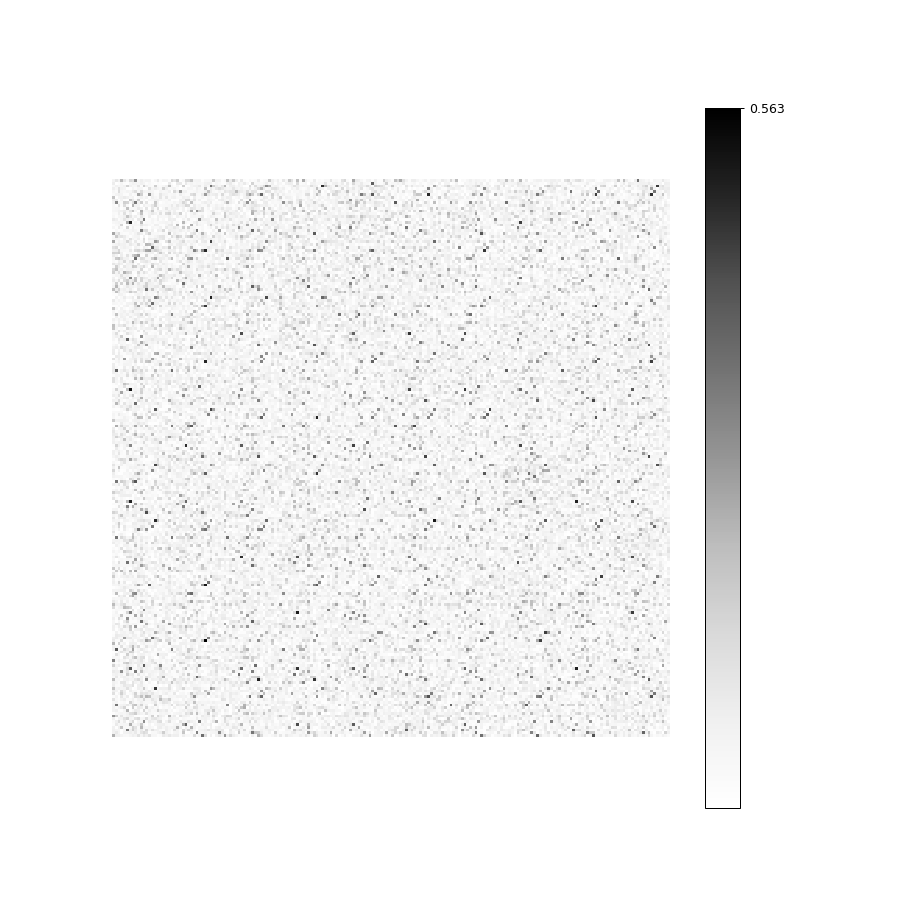

100%|██████████| 10000/10000 [00:09<00:00, 1093.24it/s]


In [53]:
%matplotlib notebook
fig1 = plt.figure(figsize=(10, 10))
# fig2 = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 1, (iN, sN))
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        io_p = cp.maximum((2 * io_b) - io_bb, 0)
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io

#     draw_weights(sw.get(), Kx, Ky, sl, fig1)
    draw_weights(iw.get(), Ix, Iy, Kx, fig1)

Hmm, that's actually kinda looking like more of what I would have expected.

<IPython.core.display.Javascript object>


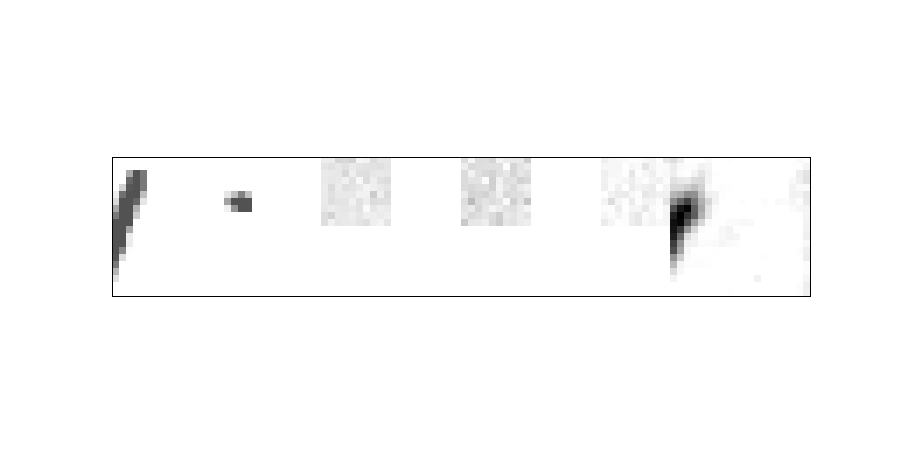

100%|██████████| 500/500 [00:00<00:00, 550.58it/s]


In [56]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))

for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    io_p = np.maximum((2 * io_b) - io_bb, 0)
    
    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Yeah, it's still not great.  Ok, so instead of trying to predict n from n-1 and n-2, and I'm going to try to do n-1 from n and n-2.  Basically just take an average.  That should hopefully prevent things from getting too chaotic.

<IPython.core.display.Javascript object>


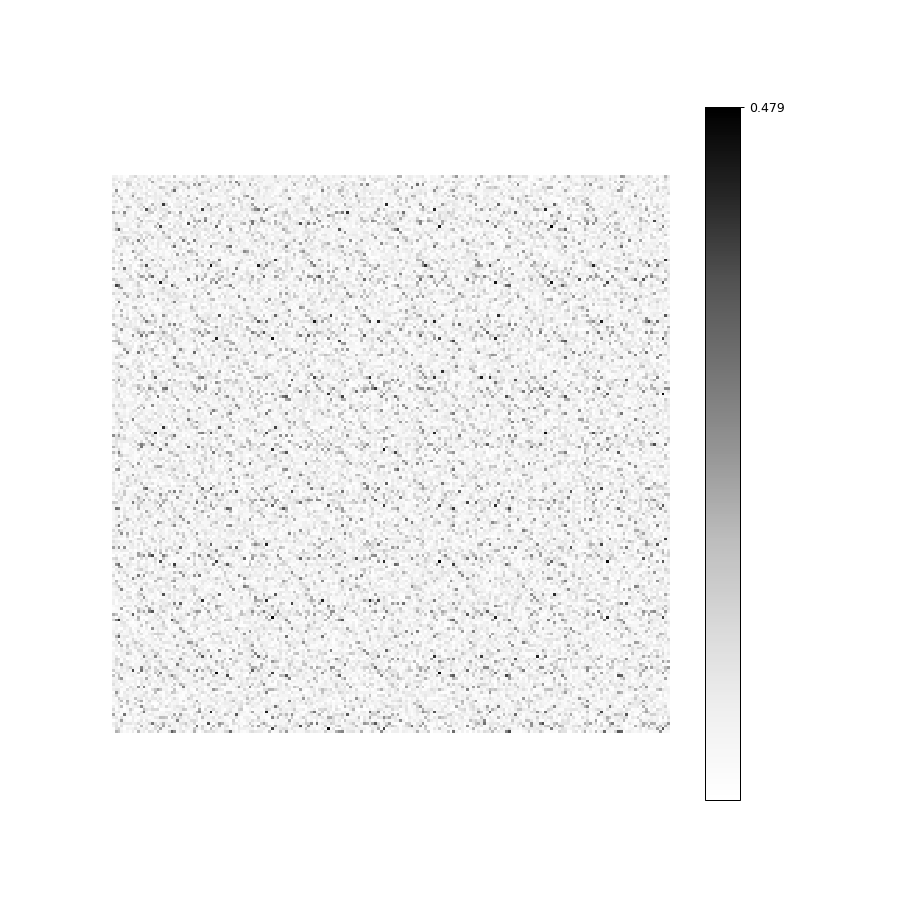

100%|██████████| 10000/10000 [00:09<00:00, 1050.37it/s]


In [57]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.04

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 1, (iN, sN))
zeta = 0.01


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    so_b = cp.zeros((sN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io = iw @ so
        
        io_p = (io + io_bb) / 2
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so_b > 0, so_b - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io
        
        so_b = so

    draw_weights(iw.get(), Ix, Iy, Kx, fig)

Ok, I'm a little nervous just because a lot of them are kinda randomly looking homogenous.  Here are the prototypes overlaid by the invariances.

<IPython.core.display.Javascript object>


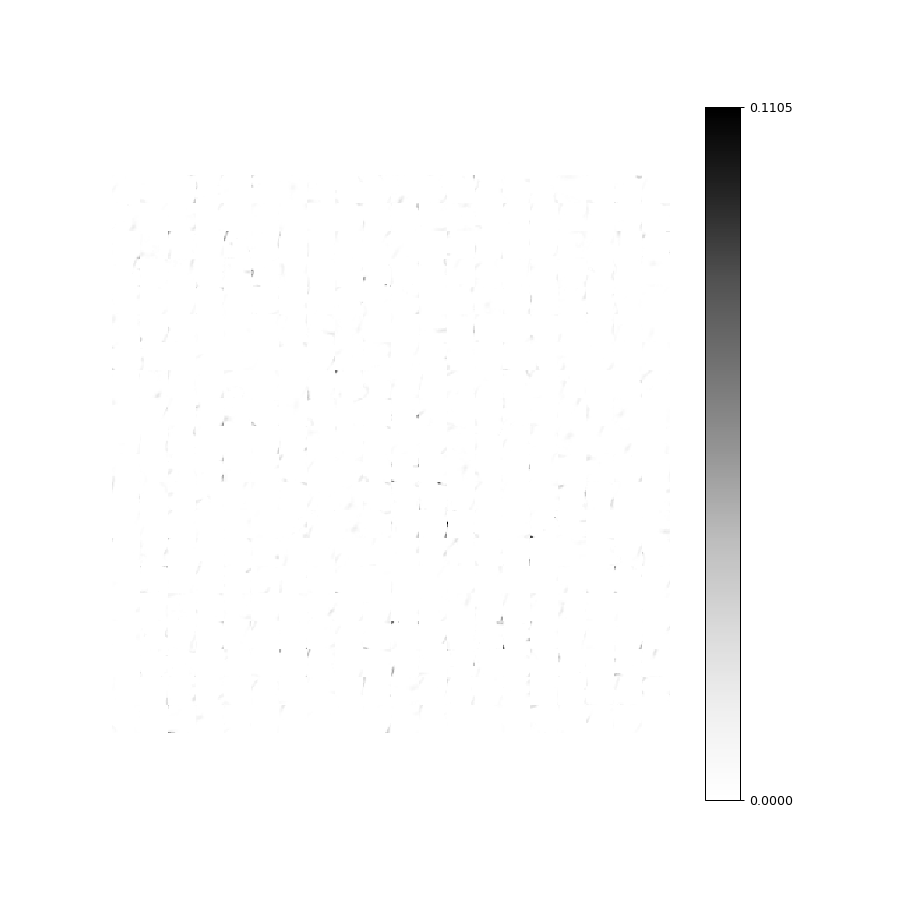

In [61]:
fig = plt.figure(figsize=(10, 10))

draw_weights((sw * iw[2].reshape(-1, 1)).get(), Kx, Ky, sl, fig)

Weird.  Here's the animation:

<IPython.core.display.Javascript object>


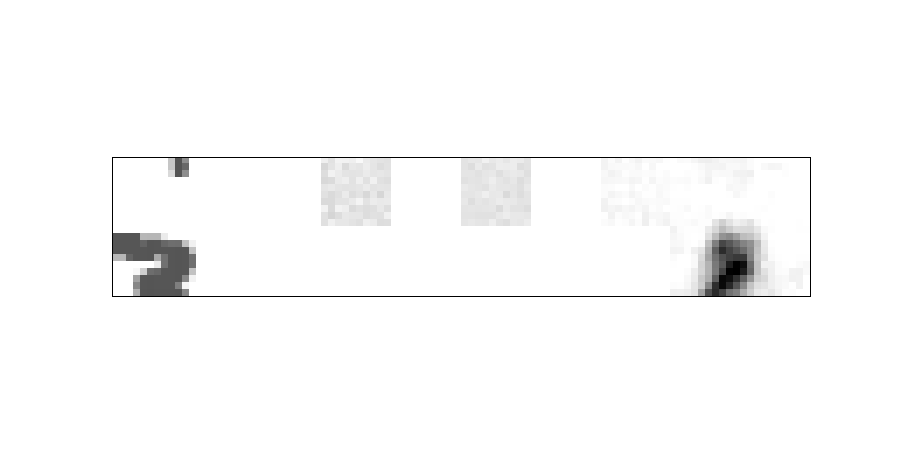

100%|██████████| 500/500 [00:00<00:00, 550.27it/s]


In [62]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io = iw_np @ so
    
    io_p = (io + io_bb) / 2
    
    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io_bb.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io_bb - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Yikes.  It looks like a gigantic pile of mush.  I need to do something to promote greater orthogonality.

I think I'm just going to wrap this up, and turn off the ol' p-instance for the time being.

## Conclusions

The results were...underwhelming.  However, it's not entirely unexpected that the network would misbehave on my first iteration.  

To kinda sum up what I just saw, when I used the linear extrapolation, the prediction was pretty chaotic, and so I think the learning was generally also chaotic.  

However, when I used linear interpolation, the result was basically a big pile of mush.  Also if you look at the invariant prototypes, they're incredibly homogenous.  You know what that makes me think?  I need sparsity.  I think I simply need sparsity in the invariant layer.  Maybe constrain it so that only so many neurons are on at a time...well, I mean that is what sparsity is.  

Yeah, I think that's what I have to do.  In many ways, that's actually pretty similar to my first efforts at creating neural networks.  Just a ton of homogeneity.  That was essentially the curse of the fuzzy three.  

Hmm.  This is super interesting.  However, I still have a couple concerns about using that sort of architecture.  I think I'm going to take a walk and try to think about how to do this in a good way.

## Next steps

Sparse invariance, I guess.  It's actually kinda funny.  Before this experiment began, I was thinking about how sometimes it doesn't feel like I'm actually making any progress.  I was thinking that maybe I could go back and look at all the different brain waves I've had over the past 6 months, and notice the trend of progression.  

I never even paused to consider adding sparsity to the invariant layer would be a good idea.  But, I mean, it totally makes sense.  So yeah, there's an example of intellectual progress right there, Danny.

So yeah, next steps:

* Sparse invariance
* Sparse invariance
* Sparse invariance